In [1]:
# Install required libraries
!pip install -q diffusers[training] transformers accelerate datasets torchvision bitsandbytes peft
!pip install -q git+https://github.com/huggingface/accelerate
!pip install -q safetensors scikit-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 99.0 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 24.4 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 27.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━

In [2]:
# Set environment variables
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
os.environ["XFORMERS_FORCE_DISABLE_TRITON"] = "1"

# Import libraries
import gc
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from diffusers import StableDiffusionInpaintPipeline, UNet2DConditionModel, DDPMScheduler, AutoencoderKL
from transformers import CLIPTextModel, CLIPTokenizer
from accelerate import Accelerator
from tqdm.auto import tqdm
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import bitsandbytes as bnb
from peft import LoraConfig, get_peft_model
import matplotlib.pyplot as plt
import random
from torchvision.transforms.functional import to_pil_image

2025-09-21 09:58:31.364250: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758448711.591734      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758448711.658072      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Configuration
DATASET_PATH = "/kaggle/input/ammonite-fossils/dataset"
OUTPUT_DIR = "/kaggle/working/sd_fossil_lora"

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

MODEL_NAME = "runwayml/stable-diffusion-inpainting"
PROMPT = "reconstructed ammonite fossil scan with detailed structures"
BATCH_SIZE = 2
GRADIENT_ACCUMULATION_STEPS = 4
EPOCHS = 10
LEARNING_RATE = 1e-4
RESOLUTION = 256
MASK_THRESHOLD = 25
TEST_SAMPLES = 4
LORA_RANK = 32

In [4]:
# Initialize accelerator
accelerator = Accelerator(
    mixed_precision='fp16',
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    log_with="tensorboard",
    project_dir=os.path.join(OUTPUT_DIR, "logs")
)
device = accelerator.device

In [5]:
# Custom dataset class with mask generation
class FossilDataset(Dataset):
    def __init__(self, base_path, split="train", transform=None):
        self.damaged_path = os.path.join(base_path, split, "damaged")
        self.original_path = os.path.join(base_path, split, "images")
        self.image_files = [f for f in os.listdir(self.original_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
        self.transform = transform or transforms.Compose([
            transforms.Resize(RESOLUTION),
            transforms.CenterCrop(RESOLUTION),
            transforms.ToTensor()
        ])
        
    def __len__(self):
        return len(self.image_files)
    
    def generate_mask(self, original, damaged):
        orig_np = np.array(original).astype(np.int16)
        dam_np = np.array(damaged).astype(np.int16)
        diff = np.abs(orig_np - dam_np)
        combined_diff = np.max(diff, axis=-1)
        mask = (combined_diff > MASK_THRESHOLD).astype(np.uint8) * 255
        return Image.fromarray(mask)
    
    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        original = Image.open(os.path.join(self.original_path, img_name)).convert("RGB")
        damaged_name = img_name.replace('.png', '_damaged.png')
        damaged = Image.open(os.path.join(self.damaged_path, damaged_name)).convert("RGB")
        mask = self.generate_mask(original, damaged)
        
        original = self.transform(original)
        damaged = self.transform(damaged)
        mask = self.transform(mask)
        mask = (mask > 0.5).float()
        
        return {
            "original": original,
            "masked_image": damaged,
            "mask": mask,
            "file_name": img_name
        }

In [6]:
# Create datasets
train_dataset = FossilDataset(DATASET_PATH, "train")
val_dataset = FossilDataset(DATASET_PATH, "val")
test_dataset = FossilDataset(DATASET_PATH, "test")

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True)

In [7]:
# Load model components
tokenizer = CLIPTokenizer.from_pretrained(MODEL_NAME, subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(MODEL_NAME, subfolder="text_encoder")
vae = AutoencoderKL.from_pretrained(MODEL_NAME, subfolder="vae")
unet = UNet2DConditionModel.from_pretrained(MODEL_NAME, subfolder="unet")
noise_scheduler = DDPMScheduler.from_pretrained(MODEL_NAME, subfolder="scheduler")

# Freeze base models
text_encoder.requires_grad_(False)
vae.requires_grad_(False)
unet.requires_grad_(False)  # Will unfreeze LoRA params

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

text_encoder/pytorch_model.bin:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

An error occurred while trying to fetch runwayml/stable-diffusion-inpainting: runwayml/stable-diffusion-inpainting does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


vae/diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/748 [00:00<?, ?B/s]

An error occurred while trying to fetch runwayml/stable-diffusion-inpainting: runwayml/stable-diffusion-inpainting does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


unet/diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

UNet2DConditionModel(
  (conv_in): Conv2d(9, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_features=320, out_features=320, bias=False)
                (to_v): Linear(in_features=320, out_fe

In [ ]:
# LoRA configuration for Stable Diffusion UNet
lora_config = LoraConfig(
    r=LORA_RANK,
    lora_alpha=LORA_RANK*2,
    target_modules=["to_q", "to_k", "to_v", "proj"],
    init_lora_weights="gaussian",
    lora_dropout=0.05,
)

# Apply LoRA only to UNet (text encoder not needed for reconstruction)
unet = get_peft_model(unet, lora_config)

# Enable gradient checkpointing
unet.enable_gradient_checkpointing()

# Move models to device
text_encoder.to(device)
vae.to(device)
unet.to(device)

PeftModel(
  (base_model): LoraModel(
    (model): UNet2DConditionModel(
      (conv_in): Conv2d(9, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (time_proj): Timesteps()
      (time_embedding): TimestepEmbedding(
        (linear_1): Linear(in_features=320, out_features=1280, bias=True)
        (act): SiLU()
        (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
      )
      (down_blocks): ModuleList(
        (0): CrossAttnDownBlock2D(
          (attentions): ModuleList(
            (0-1): 2 x Transformer2DModel(
              (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
              (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
              (transformer_blocks): ModuleList(
                (0): BasicTransformerBlock(
                  (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
                  (attn1): Attention(
                    (to_q): lora.Linear(
                      (base_layer): Linear(in_feat

In [9]:
# Initialize pipeline
inference_pipe = StableDiffusionInpaintPipeline(
    vae=vae,
    text_encoder=text_encoder,
    tokenizer=tokenizer,
    unet=unet,
    scheduler=noise_scheduler,
    safety_checker=None,
    feature_extractor=None
).to(device)

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [10]:
# Prepare text embeddings
text_input = tokenizer(
    [PROMPT] * BATCH_SIZE, 
    padding="max_length",
    max_length=tokenizer.model_max_length,
    truncation=True,
    return_tensors="pt"
)
with torch.no_grad():
    fixed_text_embeddings = text_encoder(text_input.input_ids.to(device))[0]

# 8-bit AdamW optimizer (only for UNet LoRA params)
optimizer = bnb.optim.AdamW8bit(
    unet.parameters(),  # Only optimize LoRA parameters
    lr=LEARNING_RATE,
    weight_decay=1e-6
)

# Prepare for training
unet, optimizer, train_loader, val_loader = accelerator.prepare(
    unet, optimizer, train_loader, val_loader
)

In [11]:
def train_epoch(epoch):
    unet.train()
    total_loss = 0
    
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch}", disable=not accelerator.is_local_main_process)
    for batch_idx, batch in enumerate(progress_bar):
        with accelerator.accumulate(unet):
            current_batch_size = batch["original"].shape[0]
            text_embeddings = fixed_text_embeddings[:current_batch_size]
            
            with torch.no_grad():
                latents = vae.encode(batch["original"].to(device)).latent_dist.sample() * 0.18215
                masked_latents = vae.encode(batch["masked_image"].to(device)).latent_dist.sample() * 0.18215
                mask = F.interpolate(batch["mask"].to(device), size=latents.shape[-2:])
            
            noise = torch.randn_like(latents)
            timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (current_batch_size,), device=device)
            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)
            
            inputs = torch.cat([noisy_latents, mask, masked_latents], dim=1)
            
            with accelerator.autocast():
                noise_pred = unet(inputs, timesteps, encoder_hidden_states=text_embeddings).sample
                loss = F.mse_loss(noise_pred, noise)
            
            accelerator.backward(loss)
            if accelerator.sync_gradients:
                accelerator.clip_grad_norm_(unet.parameters(), 1.0)
            optimizer.step()
            optimizer.zero_grad()
            
            total_loss += loss.detach().item()
            progress_bar.set_postfix(loss=loss.item())
        
        if batch_idx % 10 == 0:
            gc.collect()
            torch.cuda.empty_cache()
    
    avg_loss = total_loss / len(train_loader)
    accelerator.log({"train_loss": avg_loss}, step=epoch)
    return avg_loss

In [12]:
def evaluate_and_sample(epoch):
    unet.eval()
    val_loss = 0
    
    with torch.no_grad():
        for batch in val_loader:
            current_batch_size = batch["original"].shape[0]
            text_embeddings = fixed_text_embeddings[:current_batch_size]
            
            latents = vae.encode(batch["original"].to(device)).latent_dist.sample() * 0.18215
            masked_latents = vae.encode(batch["masked_image"].to(device)).latent_dist.sample() * 0.18215
            mask = F.interpolate(batch["mask"].to(device), size=latents.shape[-2:])
            
            noise = torch.randn_like(latents)
            timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (current_batch_size,), device=device)
            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)
            
            inputs = torch.cat([noisy_latents, mask, masked_latents], dim=1)
            
            noise_pred = unet(inputs, timesteps, encoder_hidden_states=text_embeddings).sample
            loss = F.mse_loss(noise_pred, noise)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_loader)
    accelerator.log({"val_loss": avg_val_loss}, step=epoch)
    
    if accelerator.is_local_main_process:
        test_batch = next(iter(test_loader))
        psnr_values = []
        ssim_values = []
        
        plt.figure(figsize=(12, 4 * min(TEST_SAMPLES, len(test_batch["original"]))))
        
        for i in range(min(TEST_SAMPLES, len(test_batch["original"]))):
            image = test_batch["masked_image"][i].unsqueeze(0).to(device)
            mask = test_batch["mask"][i].unsqueeze(0).to(device)
            
            with torch.autocast(device.type):
                reconstructed = inference_pipe(
                    image=image,
                    mask_image=mask,
                    prompt=PROMPT,
                    height=RESOLUTION,
                    width=RESOLUTION,
                    num_inference_steps=50,
                    guidance_scale=1.0,
                    output_type="pil"
                ).images[0]
            
            original = transforms.ToPILImage()(test_batch["original"][i].cpu())
            masked = transforms.ToPILImage()(test_batch["masked_image"][i].cpu())
            mask_img = transforms.ToPILImage()(test_batch["mask"][i].cpu())
            
            # Resize reconstructed to match original before metrics
            reconstructed = reconstructed.resize(original.size)
            
            # Convert to numpy for metrics
            original_np = np.array(original)
            recon_np = np.array(reconstructed)
            
            psnr = peak_signal_noise_ratio(original_np, recon_np)
            ssim = structural_similarity(original_np, recon_np, channel_axis=2)
            
            psnr_values.append(psnr)
            ssim_values.append(ssim)
            
            # Plot 4 images side-by-side
            for j, (img, title) in enumerate([
                (original, "Original"),
                (masked, "Damaged"),
                (mask_img, "Mask"),
                (reconstructed, f"Reconstructed\nPSNR={psnr:.2f}, SSIM={ssim:.3f}")
            ]):
                plt.subplot(min(TEST_SAMPLES, len(test_batch["original"])), 4, i*4 + j + 1)
                plt.imshow(img)
                plt.title(title)
                plt.axis("off")
        
        plt.tight_layout()
        plt.show()
        
        # Log average metrics
        avg_psnr = np.mean(psnr_values)
        avg_ssim = np.mean(ssim_values)
        accelerator.log({
            "test_psnr": avg_psnr,
            "test_ssim": avg_ssim
        }, step=epoch)
        
        print(f"Epoch {epoch} - PSNR: {avg_psnr:.2f}, SSIM: {avg_ssim:.4f}")
    
    return avg_val_loss

Epoch 1:   0%|          | 0/1578 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

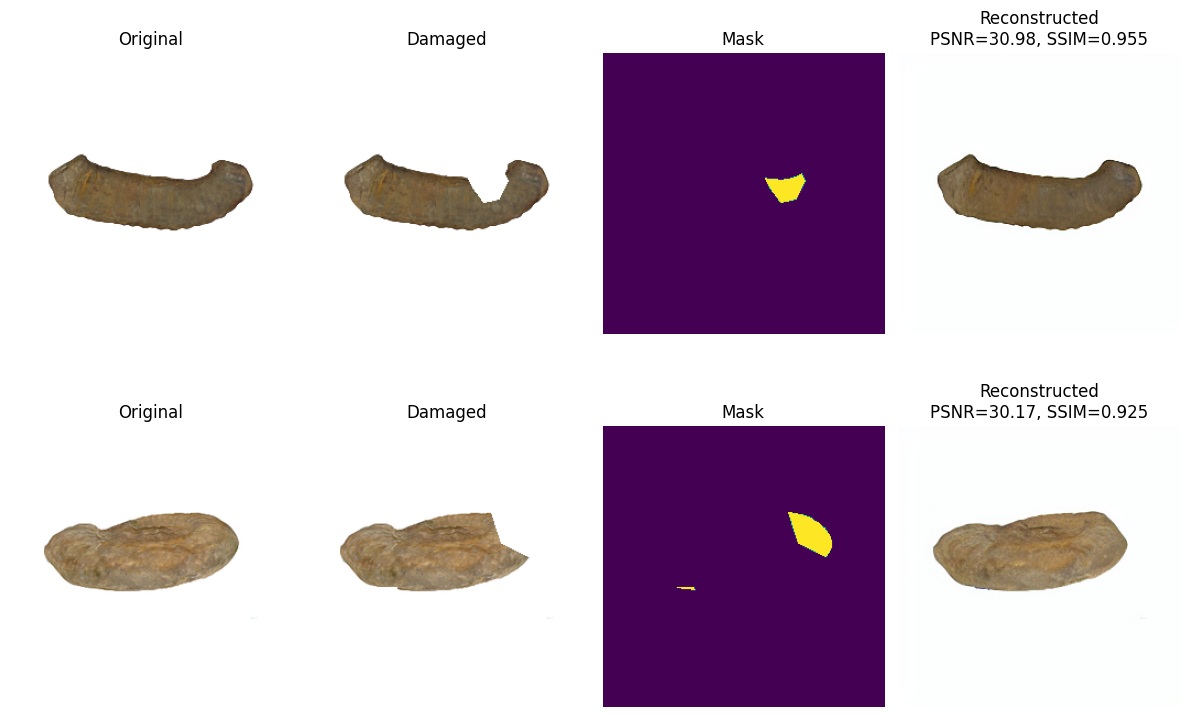

Epoch 1 - PSNR: 30.57, SSIM: 0.9397
Saved checkpoint to /kaggle/working/sd_fossil_lora/checkpoint_epoch_1
Epoch 1/10 | Train Loss: 0.0240 | Val Loss: 0.0198


Epoch 2:   0%|          | 0/1578 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

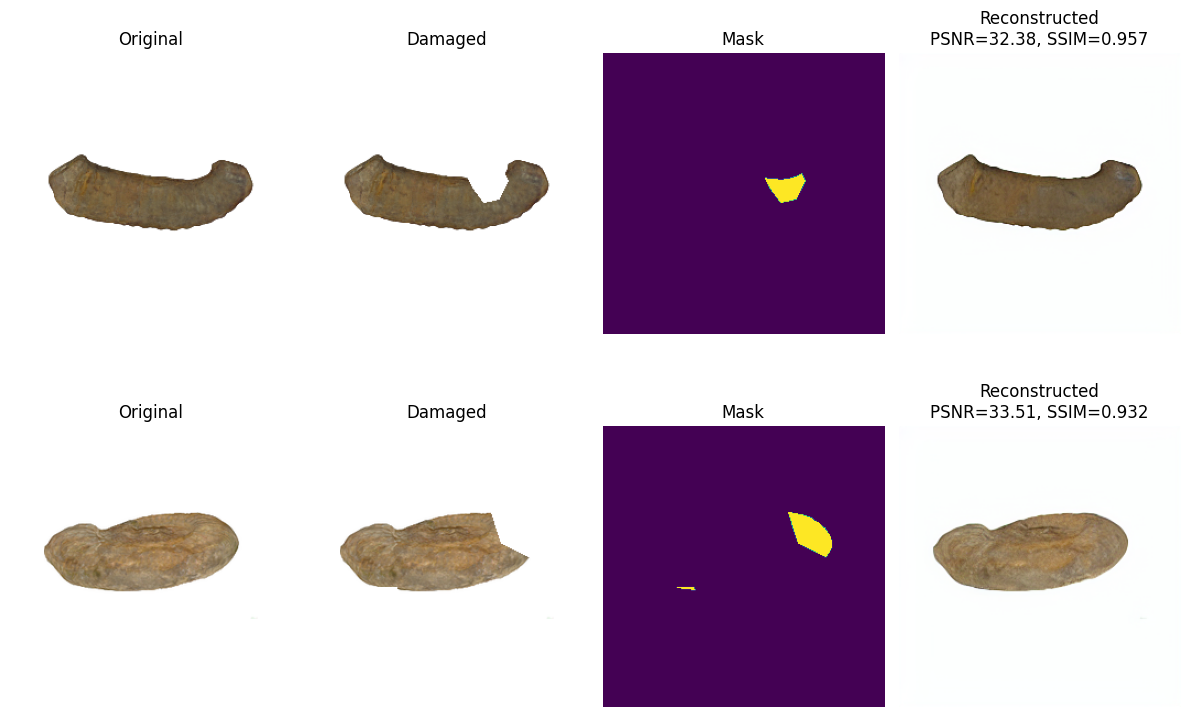

Epoch 2 - PSNR: 32.95, SSIM: 0.9444
Saved checkpoint to /kaggle/working/sd_fossil_lora/checkpoint_epoch_2
Epoch 2/10 | Train Loss: 0.0234 | Val Loss: 0.0223


Epoch 3:   0%|          | 0/1578 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

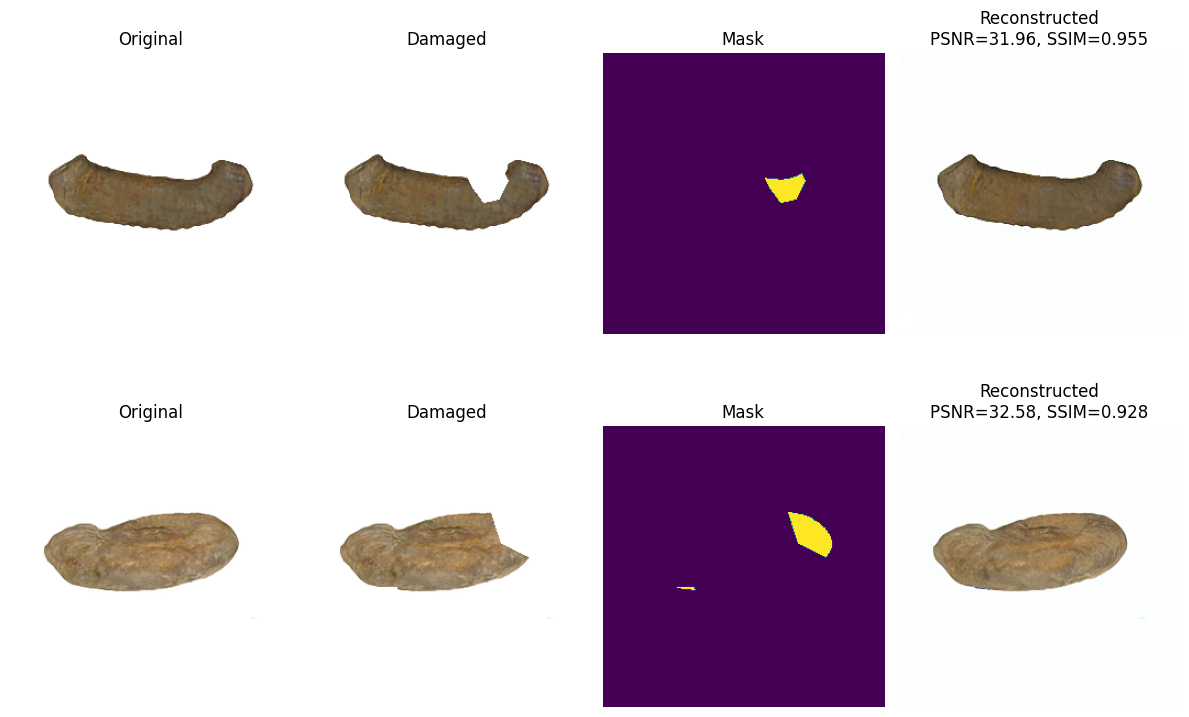

Epoch 3 - PSNR: 32.27, SSIM: 0.9414
Saved checkpoint to /kaggle/working/sd_fossil_lora/checkpoint_epoch_3
Epoch 3/10 | Train Loss: 0.0230 | Val Loss: 0.0231


Epoch 4:   0%|          | 0/1578 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

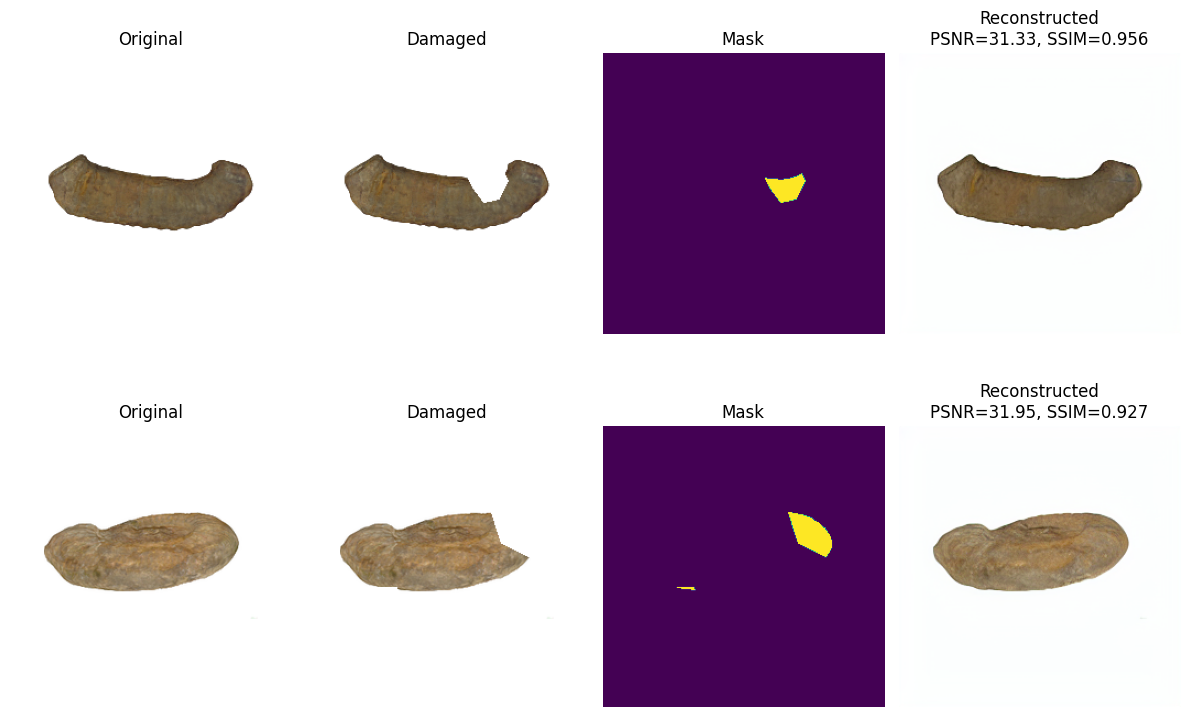

Epoch 4 - PSNR: 31.64, SSIM: 0.9412
Saved checkpoint to /kaggle/working/sd_fossil_lora/checkpoint_epoch_4
Epoch 4/10 | Train Loss: 0.0244 | Val Loss: 0.0246


Epoch 5:   0%|          | 0/1578 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

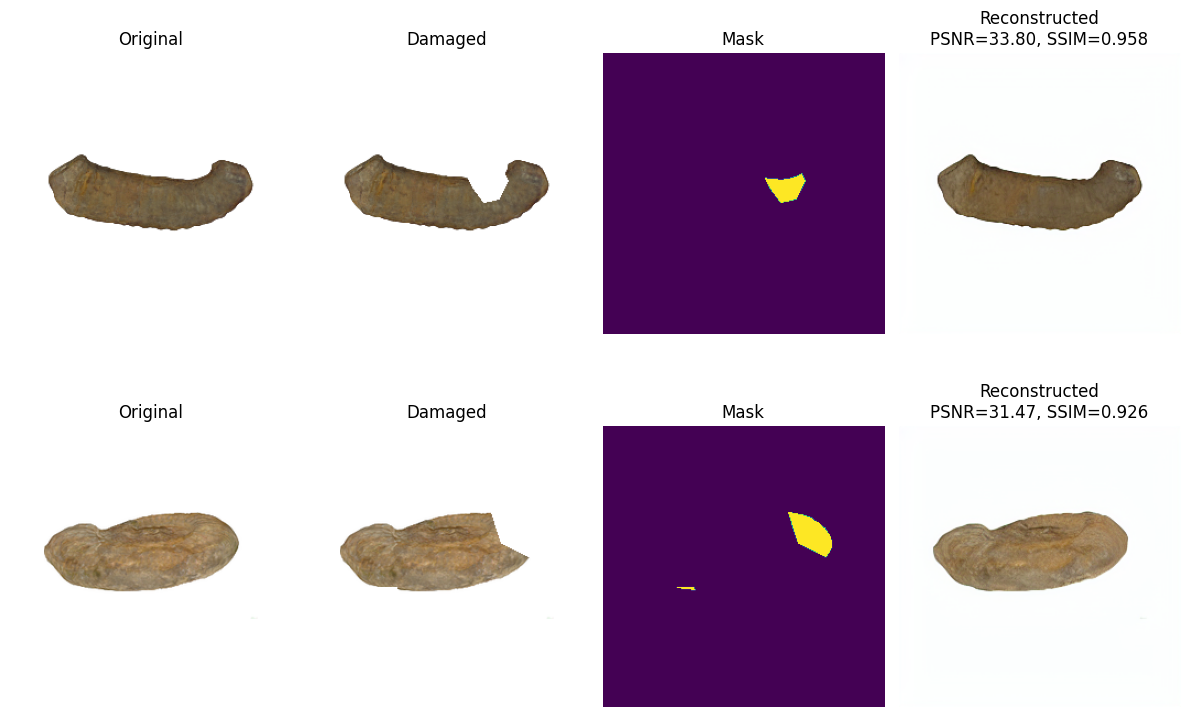

Epoch 5 - PSNR: 32.63, SSIM: 0.9419
Saved checkpoint to /kaggle/working/sd_fossil_lora/checkpoint_epoch_5
Epoch 5/10 | Train Loss: 0.0242 | Val Loss: 0.0241


Epoch 6:   0%|          | 0/1578 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

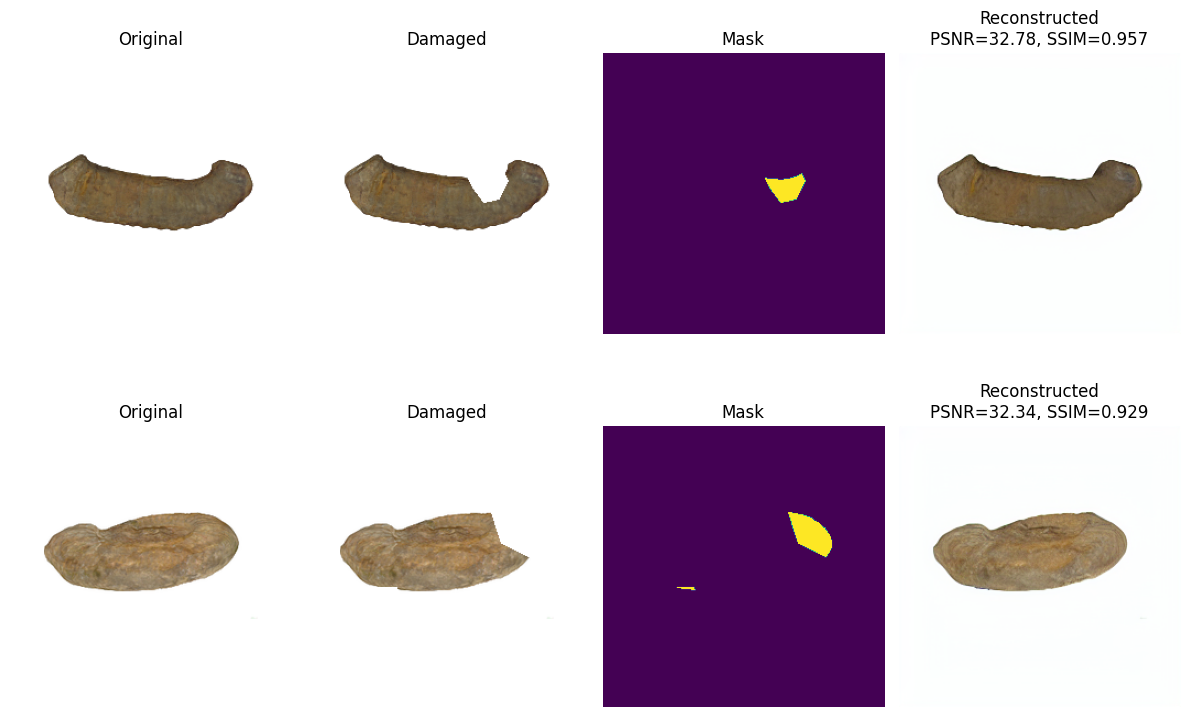

Epoch 6 - PSNR: 32.56, SSIM: 0.9432
Saved checkpoint to /kaggle/working/sd_fossil_lora/checkpoint_epoch_6
Epoch 6/10 | Train Loss: 0.0235 | Val Loss: 0.0211


Epoch 7:   0%|          | 0/1578 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

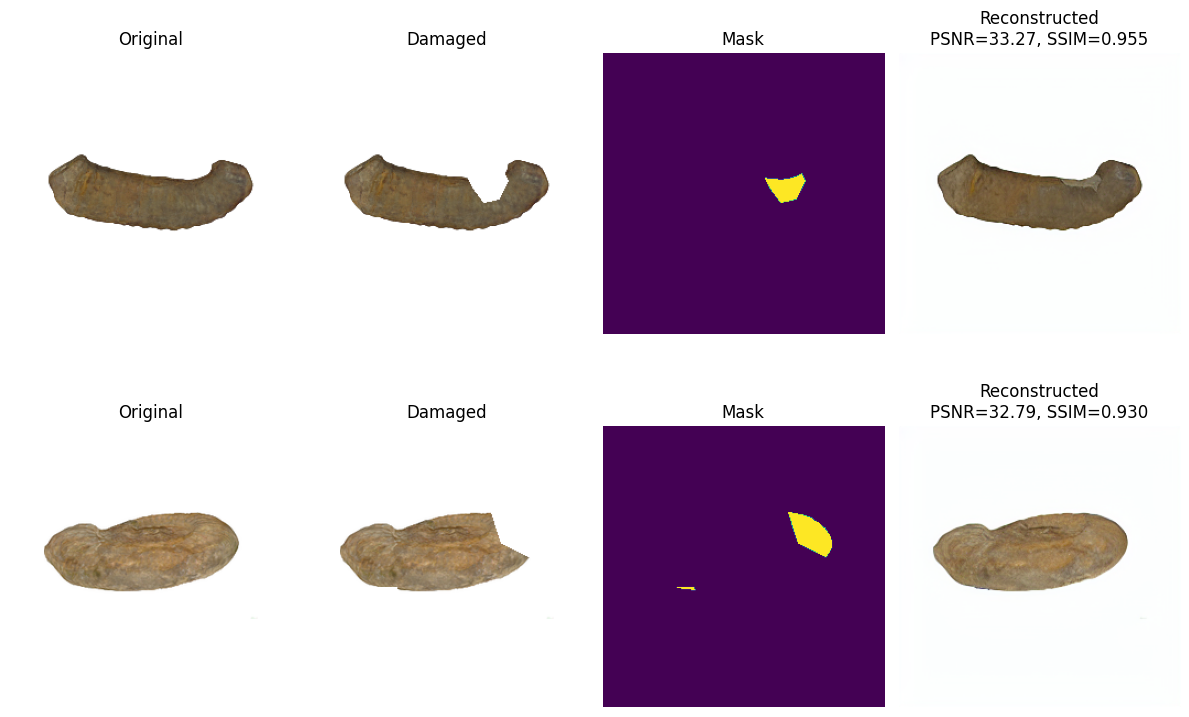

Epoch 7 - PSNR: 33.03, SSIM: 0.9426
Saved checkpoint to /kaggle/working/sd_fossil_lora/checkpoint_epoch_7
Epoch 7/10 | Train Loss: 0.0222 | Val Loss: 0.0218


Epoch 8:   0%|          | 0/1578 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

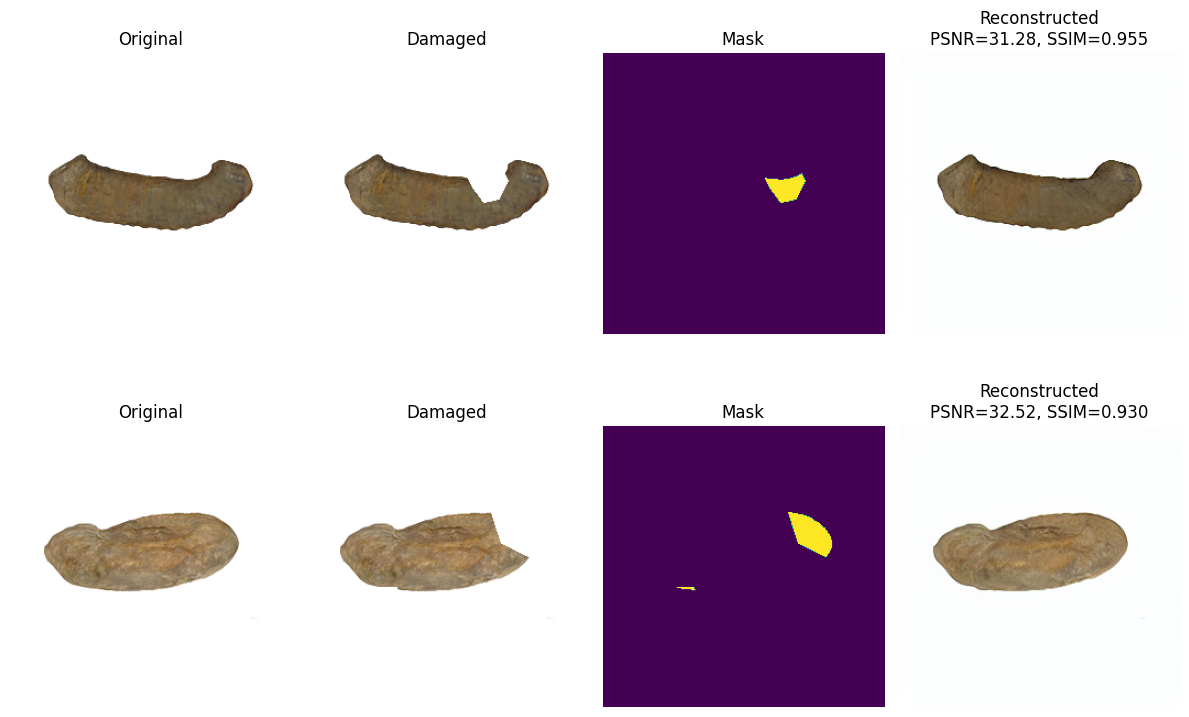

Epoch 8 - PSNR: 31.90, SSIM: 0.9422
Saved checkpoint to /kaggle/working/sd_fossil_lora/checkpoint_epoch_8
Epoch 8/10 | Train Loss: 0.0217 | Val Loss: 0.0242


Epoch 9:   0%|          | 0/1578 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

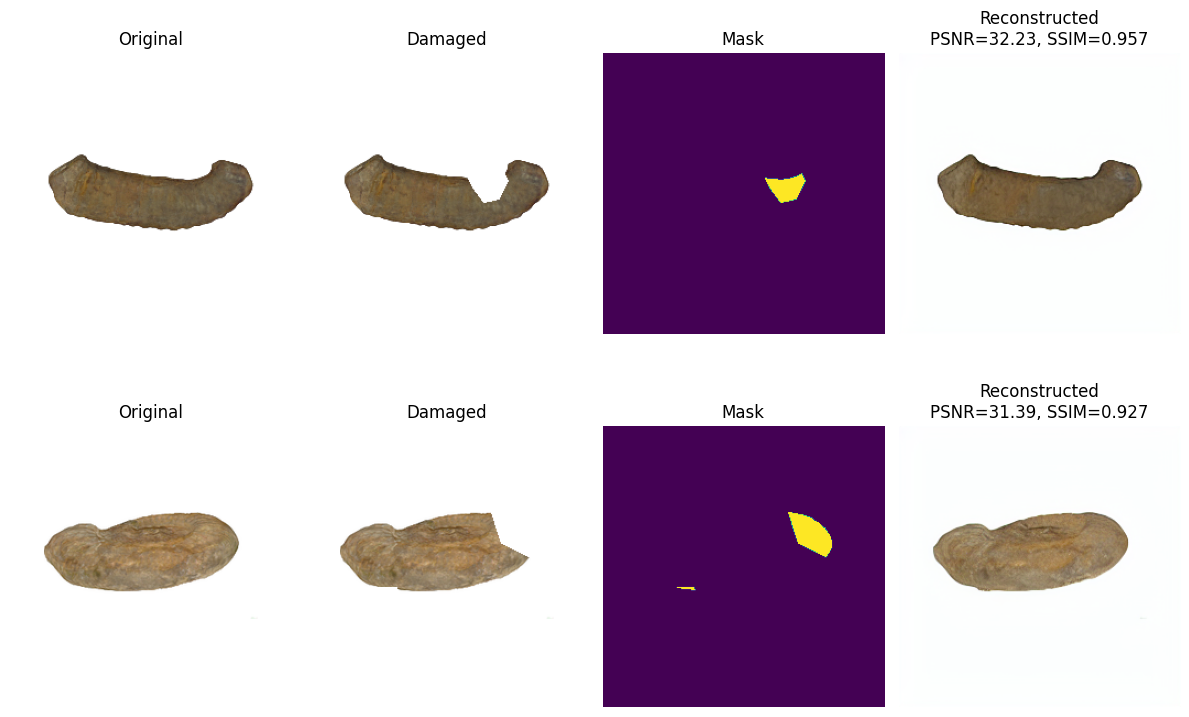

Epoch 9 - PSNR: 31.81, SSIM: 0.9420
Saved checkpoint to /kaggle/working/sd_fossil_lora/checkpoint_epoch_9
Epoch 9/10 | Train Loss: 0.0237 | Val Loss: 0.0248


Epoch 10:   0%|          | 0/1578 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

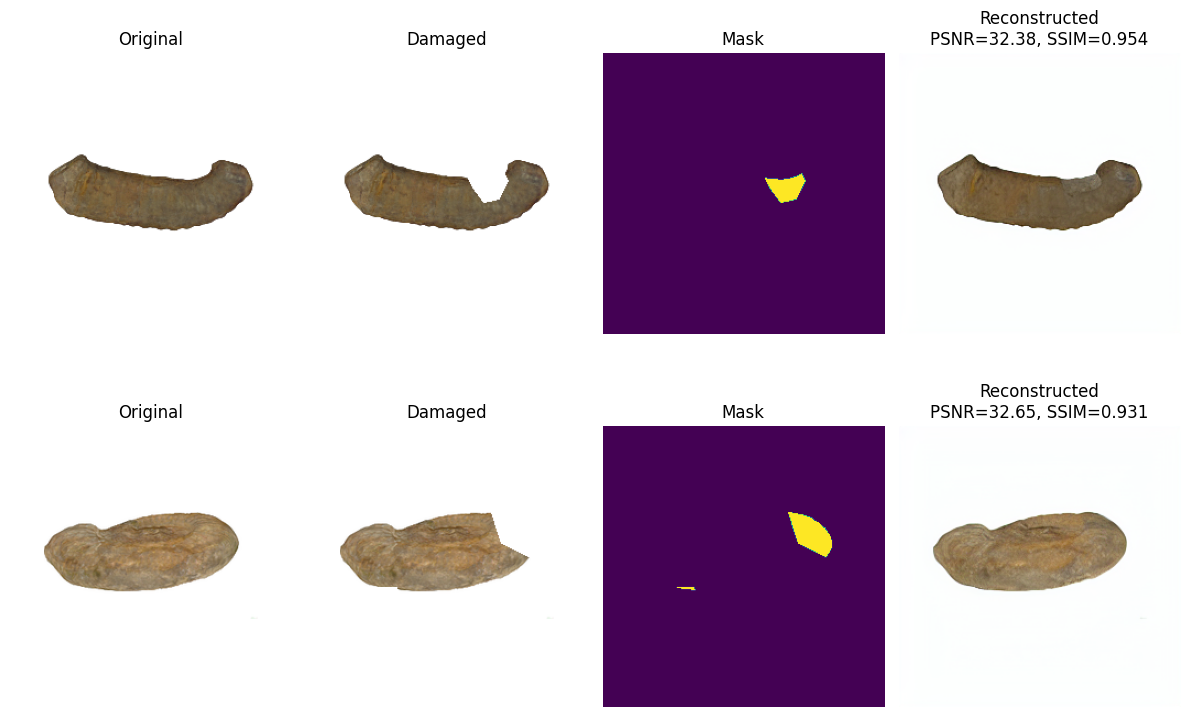

Epoch 10 - PSNR: 32.52, SSIM: 0.9425
Saved checkpoint to /kaggle/working/sd_fossil_lora/checkpoint_epoch_10
Epoch 10/10 | Train Loss: 0.0229 | Val Loss: 0.0260


In [13]:
# Main training loop
for epoch in range(1, EPOCHS + 1):
    # Clear memory
    gc.collect()
    torch.cuda.empty_cache()
    
    # Train and evaluate
    train_loss = train_epoch(epoch)
    val_loss = evaluate_and_sample(epoch)
    
    # Save checkpoint
    if accelerator.is_local_main_process:
        # Remove old checkpoints
        import shutil

        for folder in os.listdir(OUTPUT_DIR):
            path = os.path.join(OUTPUT_DIR, folder)
            if folder.startswith("checkpoint_epoch_") and os.path.isdir(path):
                shutil.rmtree(path)

        checkpoint_path = os.path.join(OUTPUT_DIR, f"checkpoint_epoch_{epoch}")
        accelerator.save_state(checkpoint_path)
        print(f"Saved checkpoint to {checkpoint_path}")
    
    print(f"Epoch {epoch}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

In [14]:
# Final model save
accelerator.wait_for_everyone()
if accelerator.is_main_process:
    # Save LoRA weights
    unet = accelerator.unwrap_model(unet)
    unet.save_pretrained(os.path.join(OUTPUT_DIR, "fossil_lora_unet"))
    print(f"Saved fossil reconstruction LoRA weights to {OUTPUT_DIR}")

Saved fossil reconstruction LoRA weights to /kaggle/working/sd_fossil_lora


In [18]:
from peft import PeftModel

# Create inference function
def load_fossil_pipeline():
    pipe = StableDiffusionInpaintPipeline.from_pretrained(
        MODEL_NAME,
        torch_dtype=torch.float16
    ).to(device)

    # Load PEFT LoRA adapter
    pipe.unet = PeftModel.from_pretrained(
        pipe.unet,
        os.path.join(OUTPUT_DIR, "fossil_lora_unet")
    )

    pipe.unet = pipe.unet.merge_and_unload()

    return pipe

Test sample in use: 119


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/50 [00:00<?, ?it/s]

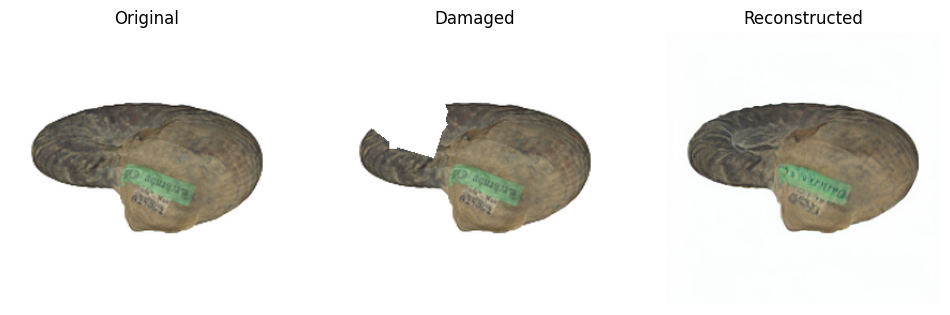

In [ ]:
# Test
idx = random.randint(0, len(test_dataset) - 1)
print(f"Test sample in use: {idx}")

sample = test_dataset[idx]

damaged_image = to_pil_image(sample["masked_image"])
original_image = to_pil_image(sample["original"])
mask = to_pil_image(sample["mask"])

fossil_pipe = load_fossil_pipeline()

with torch.autocast(device.type):
    reconstructed = fossil_pipe(
        image=damaged_image,
        mask_image=mask,
        prompt=PROMPT,
        height=RESOLUTION,
        width=RESOLUTION,
        num_inference_steps=50,
        guidance_scale=1.0,
        output_type="pil"
    ).images[0]

# Show results
plt.figure(figsize=(12, 4))
for i, (img, title) in enumerate([
    (original_image, "Original"),
    (damaged_image, "Damaged"),
    (reconstructed, "Reconstructed")
]):
    plt.subplot(1, 3, i+1)
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")
plt.show()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/50 [00:00<?, ?it/s]

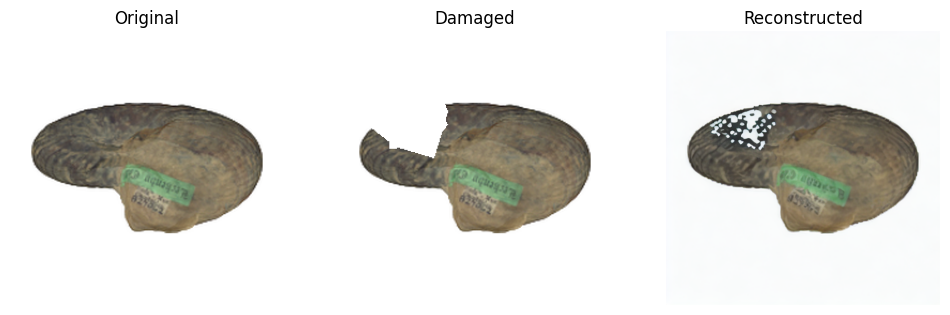

In [ ]:
# ------------------------------
# Test without fine tune
# ------------------------------
import random
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage

to_pil_image = ToPILImage()

from diffusers import StableDiffusionInpaintPipeline
import torch

# Load the pipeline (you'll need to specify the model)
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting", 
    torch_dtype=torch.float16
)
pipe = pipe.to("cuda" if torch.cuda.is_available() else "cpu")

# Generate the reconstructed image
reconstructed = pipe(
    prompt=PROMPT,
    image=original_image,
    mask_image=mask,
    num_inference_steps=50,
    guidance_scale=1.0,
    output_type="pil"
).images[0]

# Show results
plt.figure(figsize=(12, 4))
for i, (img, title) in enumerate([
    (original_image, "Original"),
    (damaged_image, "Damaged"),
    (reconstructed, "Reconstructed")
]):
    plt.subplot(1, 3, i+1)
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")
plt.show()